In [392]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import jax.numpy as jnp
from jax import grad , vmap
from matplotlib.colors import LogNorm
from ipywidgets import interact, IntSlider
from jax.scipy.spatial.transform import Rotation as R

In [393]:
def _calculate_surface_brightness(x, y, z_range ,dz, e, p, q, rho0, s, a, b):
    start , end = z_range
    z_arr = jnp.arange(start, end, dz)

    x = jnp.expand_dims(x, axis=-1)
    y = jnp.expand_dims(y, axis=-1)

    r = ((jnp.abs(x)**(2 - e) + (jnp.abs(y) / p)**(2 - e) + (jnp.abs(z_arr) / q)**(2 - e)))**(1 / (2 - e))
    den = rho0 / ((r / s)**a * (1 + (r / s))**(b - a))
    den = den/(p*q)

    den_sum = jnp.sum(den, axis = -1)

    return den_sum

def surface_brightness(x, y, z_range, dz, e, p, q, rho0, s, a, b):
    # Convert inputs to arrays
    x = jnp.asarray(x)
    y = jnp.asarray(y)

    # Check if inputs are arrays or scalars
    if x.ndim == 0:  # Scalar input
        return _calculate_surface_brightness(x, y, z_range , dz, e, p, q, rho0, s, a, b)
    else:  # Array input
        # Check if inputs have the same length
        if x.size != y.size:
            raise ValueError("Input arrays must have the same length!")
        
        squ_len = int(round(x.size ** (1/2)))
        if squ_len ** 2 != x.size:
            raise ValueError("The length of the inputs must be reshapeable into a square!")
        

        return _calculate_surface_brightness(x, y, z_range , dz, e, p, q, rho0, s, a, b).reshape((squ_len, squ_len))

In [394]:
def _calculate_gradient_surface_brightness(x, y, z_range, dz, e, p, q, rho0, s, a, b, arg_num):
    grad_rho = grad(surface_brightness, argnums=arg_num)
    return grad_rho(x, y, z_range, dz, e, p, q, rho0, s, a, b)

def gradient_surface_brightness(x, y, z_range, dz, e, p, q, rho0, s, a, b, arg_num):
    # Convert inputs to arrays
    x = np.asarray(x)
    y = np.asarray(y)
    
    
    if not arg_num:
        raise ValueError("arg_num cannot be empty. Specify the arguments to differentiate with respect to.")
    
    # Check if inputs are arrays or scalars
    if x.ndim == 0:  # Scalar input
        return _calculate_gradient_surface_brightness(x, y, z_range, dz, e, p, q, rho0, s, a, b, arg_num)
    else:  # Array input
        # Check if inputs have the same length
        if x.size != y.size:
            raise ValueError("Input arrays must have the same length!")
        
        # Define the function to compute the gradient
        grad_rho = grad(surface_brightness, argnums=arg_num)

        # Vectorize the gradient function
        vmap_grad_rho = vmap(lambda x, y: grad_rho(x, y, z_range, dz, e, p, q, rho0, s, a, b), in_axes=(0, 0))

        # Compute the gradients
        gradients = vmap_grad_rho(x, y)

        # Reshape and stack the gradients
        squ_len = int(round(x.size ** (1/2)))
        reshaped_gradients = [jnp.reshape(g, (squ_len,squ_len)) for g in gradients]

        # Stack gradients along the last axis
        stacked_gradients = jnp.stack(reshaped_gradients, axis=-1)
        
        return stacked_gradients

In [395]:
def plot_img(proj_density_mat, extent, title = '' ):
    plt.imshow(proj_density_mat.T, origin= 'lower', extent=extent)
    cbar = plt.colorbar(label='Color Scale')
    #cbar.set_ticks([np.min(proj_density_mat), np.max(proj_density_mat)])

    # Optionally, set tick labels to the min and max of your data
    #cbar.set_ticklabels([np.min(proj_density_mat), np.max(proj_density_mat)])

    min_val = np.min(proj_density_mat)
    max_val = np.max(proj_density_mat)
    num_ticks = 5  # Number of ticks between min and max
    ticks = np.linspace(min_val, max_val, num_ticks + 2)[1:-1]  # Exclude min and max
    cbar.set_ticks(ticks)

    # Optionally, set tick labels to match the ticks
    cbar.set_ticklabels(["{:.8f}".format(tick) for tick in ticks])


    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')

    plt.show()

In [396]:
def plot_img_logscale(proj_density_mat):
    """
    Plot a 2D image with a logarithmically scaled colour bar.

    Parameters:
    - proj_density_mat (numpy.ndarray): The 2D density matrix representing the density distribution projected along the z-axis.
                                    

    Returns:
    None

    This function uses Plotly matplotlib
    to create and display an image plot of the projected density with a logarithmically scaled colour bar..
    """
    plt.imshow(proj_density_mat.T, norm=colors.LogNorm(vmin=proj_density_mat.min(), vmax=proj_density_mat.max()), origin='lower')
    plt.colorbar(label='Color Scale')
    plt.show()

In [397]:
s = 1. 
e = 0.2
p = 0.8
q = 0.6
a = 2.
b = 4.
rho0 = 1.


# Define the size of your 3D matrix
x_size, y_size = 200, 200
ex = 50.
extent = [-ex, ex,-ex, ex]
# Create 3D coordinates
x, y = np.meshgrid(np.linspace(-ex, ex, x_size),
                      np.linspace(-ex, ex, y_size),
                     indexing = 'ij')
x = x.flatten()
y = y.flatten()


In [398]:
z_range = [-50,50]
dz = 0.1
density = surface_brightness(x, y, z_range, dz, e, p, q, rho0, s, a, b)

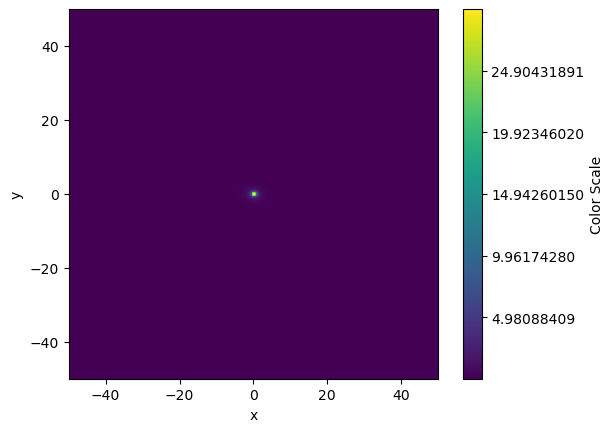

In [399]:
extent = [-ex, ex,-ex, ex]
plot_img(density,extent,"")

In [400]:
np.min(density)

Array(2.5387746e-05, dtype=float32)

In [401]:
np.max(density)

Array(29.885178, dtype=float32)

In [402]:
list_args = [0,1,4,5,6]
gradient_01 = gradient_surface_brightness(x, y, z_range, dz, e, p, q, rho0, s, a, b, list_args)

In [403]:
gradx = gradient_01[:,:,0]
grady = gradient_01[:,:,1]
grade = gradient_01[:,:,2]
gradp = gradient_01[:,:,3]
gradq = gradient_01[:,:,4]



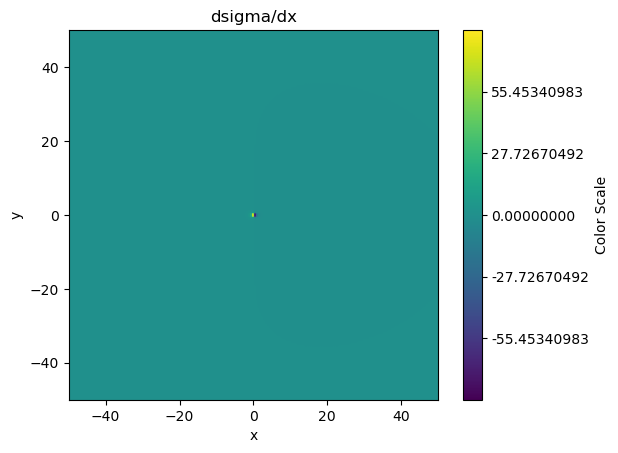

In [404]:
plot_img(gradx,extent, 'dsigma/dx')

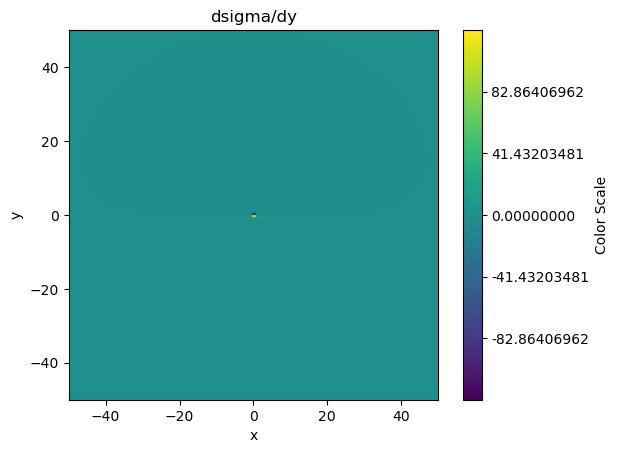

In [405]:
plot_img(grady,extent, 'dsigma/dy')

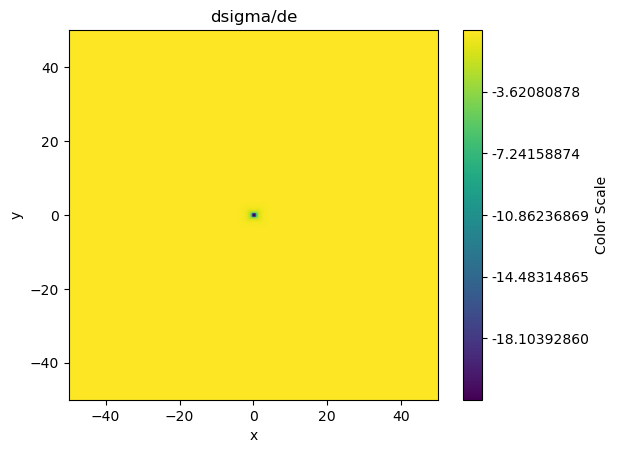

In [406]:
plot_img(grade,extent, 'dsigma/de')

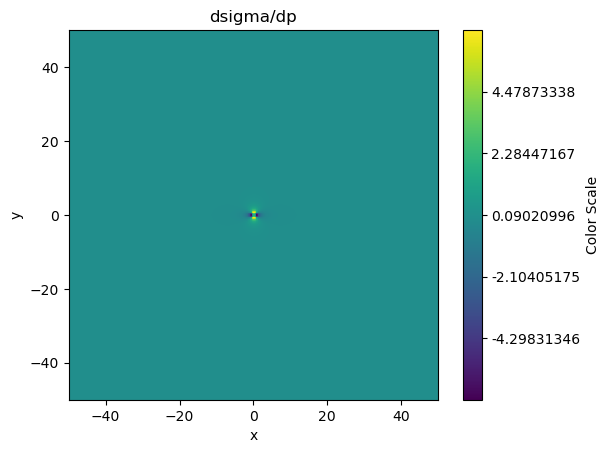

In [407]:
plot_img(gradp,extent, 'dsigma/dp')

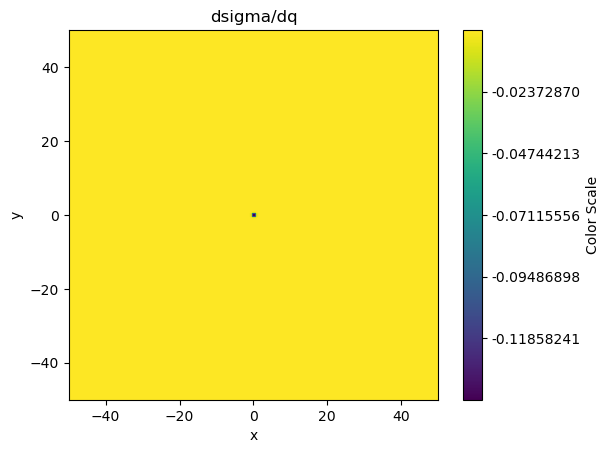

In [408]:
plot_img(gradq,extent, 'dsigma/dq')

In [409]:
np.min(gradq)

Array(-0.14229584, dtype=float32)

In [410]:
np.max(gradq)

Array(-1.5274112e-05, dtype=float32)

In [411]:
np.mean(gradq)

Array(-5.434716e-05, dtype=float32)

In [412]:
def _calculate_surface_brightness1(x, y, z_range , dz, e, p, q, rho0, s, a, b):

    start , end = z_range
    z_arr = np.arange(start, end, dz)
    den_sum = np.zeros((len(x), len(y)))  # Initialize r_sum

    for i in range(len(x)):
        for j in range(len(y)):
            r = jnp.sqrt(jnp.abs(x[i])**(2 - e) + (jnp.abs(y[j]) / p)**(2 - e) + (jnp.abs(z_arr) / q)**(2 - e))
            den = rho0 / ((r / s)**a * (1 + (r / s))**(b - a))
            den = den/(p*q)
            den_sum[i,j] = jnp.sum(den)



    return den_sum

def surface_brightness1(x, y, z_range, dz, e, p, q, rho0, s, a, b):
    # Convert inputs to arrays
    #x = np.asarray(x)
    #y = np.asarray(y)

    # Check if inputs are arrays or scalars
    if x.ndim == 0:  # Scalar input
        return _calculate_surface_brightness1(x, y, z_range , dz, e, p, q, rho0, s, a, b)
    else:  # Array input
        # Check if inputs have the same length
        if x.size != y.size:
            raise ValueError("Input arrays must have the same length!")
        
        '''squ_len = int(round(x.size ** (1/2)))
        if squ_len ** 2 != x.size:
            raise ValueError("The length of the inputs must be reshapeable into a square!")'''
        

        return _calculate_surface_brightness1(x, y, z_range , dz, e, p, q, rho0, s, a, b).reshape((len(x), len(x)))

In [413]:
x =  np.linspace(-ex, ex, x_size)
y = np.linspace(-ex, ex, y_size)


density = surface_brightness1(x, y, z_range, dz, e, p, q, rho0, s, a, b)

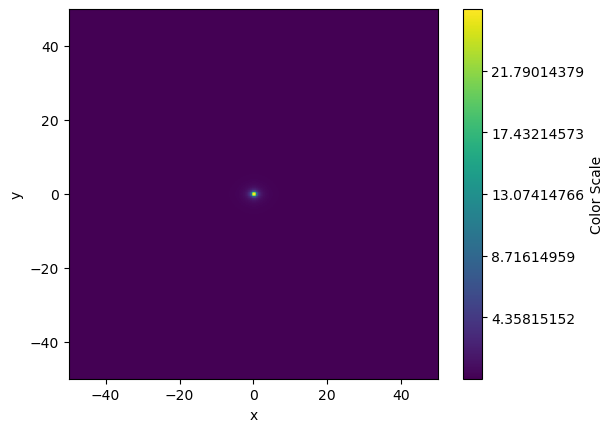

In [414]:
plot_img(density,extent,"")

In [415]:
np.min(density)

0.0001534548937343061

In [416]:
np.max(density)

26.148141860961914

In [418]:
np.mean(density)

0.012191801056000985